<a href="https://colab.research.google.com/github/ocriado91/SpocMining/blob/5-data-exploration-notebook/notebooks/00_intro_and_evalution_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to SpOC - Mine the Belt Challenge

As part of [2022 SpOC (space competition challenge)](https://www.esa.int/gsp/ACT/projects/gecco-2022-competition/) in partnership with GECCO, the ESA's Advanced Concepts Team hosted this challenge.

The goal is to optimize the route of a miner rover between an asteroid belt (10000 asteroids) to collect as much as possible material within three material types (gold, platinum, and nickel) without run-out fuel being possible to refuel at some asteroids.

# Introduction to pykep

The organizators provide us with the following [depdencies](https://optimise.esa.int/challenge/spoc-mining/Dependencies) used into the evaluation code of the challenge (we wll discuss about this code later):

* pykep >= 2.6
* matplotlib >= 3.4.3
* numpy >= 1.12.0

The `matplotlib` and `numpy` packages are well-known by the Python comunity, but the [`pykep`](https://esa.github.io/pykep/) package is an ad-hoc scientific library developed by ESA to provide basic tools for astrodynamics research hosted into [Github](https://github.com/esa/pykep)

# Installation from conda
To execute conda into the notebook we need to install `condacolab` package.

__NOTE__: We need to restart the kernel after package installation.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


And now we can install the `pykep` package using `conda`:

In [2]:
!conda install pykep

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# Input data

In this challenge, a [input data](https://api.optimize.esa.int/data/spoc/mining/candidates.txt) is provided with all asteroids into with the following format:

| ID | Semi-major axis [m] | Eccentricity | Inclination [rad] | Ascending Node [rad] | Argument of Periapsis [rad] | True Anomaly [rad] | Mass [0 to 1] | Material Type |
|:--:|:-------------------:|:------------:|:-----------------:|:--------------------:|:---------------------------:|:------------------:|:-------------:|:-------------:|
| 0  | 2.8847e10           | 1.2569e-3    | 1.5133e-1         | 2.9316               | 4.1909                      | 1.4043             | 9.2185e-1     | 0             |

In [3]:
!wget https://api.optimize.esa.int/data/spoc/mining/candidates.txt

--2024-05-10 16:11:23--  https://api.optimize.esa.int/data/spoc/mining/candidates.txt
Resolving api.optimize.esa.int (api.optimize.esa.int)... 195.169.140.114
Connecting to api.optimize.esa.int (api.optimize.esa.int)|195.169.140.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250000 (2.1M) [text/plain]
Saving to: ‘candidates.txt.3’

candidates.txt.3    100%[===================>]   2.15M  3.16MB/s    in 0.7s    

2024-05-10 16:11:24 (3.16 MB/s) - ‘candidates.txt.3’ saved [2250000/2250000]



# Data Exploration

Once the packages are installed and the `candidates` asteroids file downloaded, we can begin with the data exploration to extract the first insights of the challenge's data.

## Imports

First of all, we need to import the Python packages that we are going to use into this data exploration. At this moment, just we are going to use:

* `polars`: I'm a very fan of this package due to its performance and I use it into all my data projects.
* `pykep`: Th installed packaged into previous steps.
* `seaborn`: To generate plots.

In [4]:
import matplotlib.pyplot as plt
import polars as pl
import pykep as pk
import seaborn as sns

/usr/local/lib/python3.10/site-packages/pykep/util/gravity_spherical_harmonic.py:156: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _calculate_normalisation_parameters(n_max):


## Reading input data

We can use `polars` to read `candidates` asteroids file and store it as Dataframe, add the column headers (because they are not in the input data file), and cast `ID` and `Material Type` columns as integers to manage easier later.

In [5]:
# Set custom headers
HEADER = ["ID",
          "Semi-major axis [m]",
          "Eccentricity",
          "Inclination [rad]",
          "Ascending Node [rad]",
          "Argument of Periapsis [rad]",
          "True Anomaly [rad]",
          "Mass [0 to 1]",
          "Material Type"]

# Read asteroid candidates file
data = pl.read_csv("candidates.txt",
                   separator=" ",
                   new_columns=HEADER)

# Cast columns
data = data.cast({"ID": pl.UInt16,
           "Material Type": pl.UInt8})

# Show head
data.head()

ID,Semi-major axis [m],Eccentricity,Inclination [rad],Ascending Node [rad],Argument of Periapsis [rad],True Anomaly [rad],Mass [0 to 1],Material Type
u16,f64,f64,f64,f64,f64,f64,f64,u8
1,3.0835e10,0.008338,0.079912,3.912543,5.042492,2.617431,0.65811,3
2,2.3826e10,0.006097,0.006188,4.83121,4.589027,2.075072,0.964783,1
3,3.0512e10,0.001916,0.072551,2.277854,3.250898,1.168246,0.451917,0
4,2.9867e10,0.000553,0.013222,3.530913,4.200775,3.918279,0.668809,2
5,3.3090e10,0.004041,0.103529,2.281561,5.481973,5.145668,0.403246,2


## Analysis

So, once all python packages are installed and the input data read, we can start with our data exploration given answers to a questions:

### Q1. How many asteroids are of each type are?

According to the challenge description, the materials are equally distributed, but this is correct?

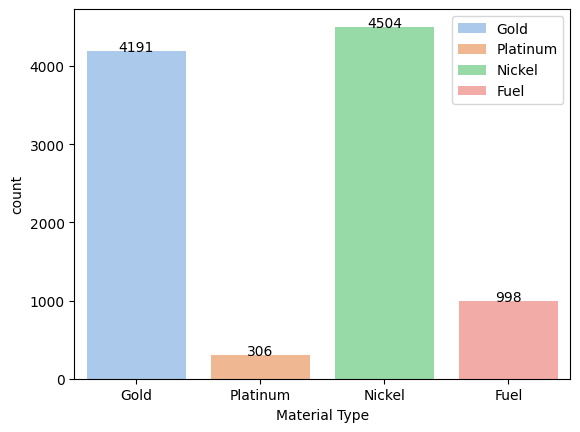

In [6]:
# Plot count
g = sns.countplot(data,
              x="Material Type",
              hue="Material Type",
              palette="pastel")

# Transform X-tick labels and legend label to material name
labels = ["Gold", "Platinum", "Nickel", "Fuel"]
g.set_xticks([0, 1, 2, 3])
g.set_xticklabels(labels)
g.legend(labels=labels)

# Extract the count of asteroids by material type
count_gold = data.filter(pl.col("Material Type") == 0).height
count_platinum = data.filter(pl.col("Material Type") == 1).height
count_nickel = data.filter(pl.col("Material Type") == 2).height
count_fuel = data.filter(pl.col("Material Type") == 3).height

# Add all counts into a list to write its values into countplot
counts = [count_gold, count_platinum, count_nickel, count_fuel]
for i in range(len(counts)):
  g.text(x=i,
         y=counts[i],
         s=str(counts[i]),
         horizontalalignment="center")

Ok, it is clear that ***we don't have a balanced distribution of asteroid by material type.***

### Q2. What is the maximum mass that the rover can mine?

According to challenge description, the final score is determined by the minimum of collected material of the tree types. So, we can obtain the theoretical maximum score according to asteroids data:

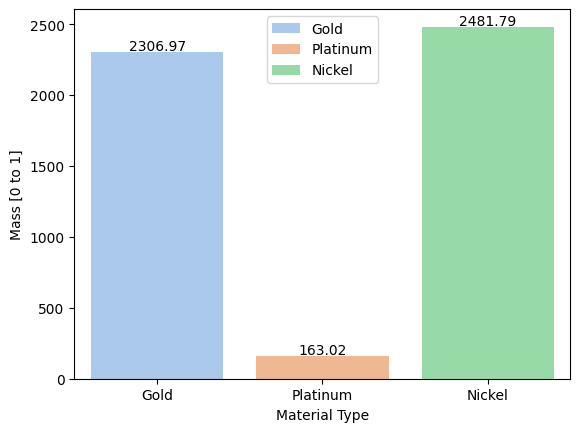

In [7]:
# Plot count
g = sns.barplot(data.filter(pl.col("Material Type") != 3),
                x="Material Type",
                y="Mass [0 to 1]",
                hue="Material Type",
                estimator="sum",
                errorbar=None,
                palette="pastel")

# Transform X-tick labels and legend label to material name
labels = ["Gold", "Platinum", "Nickel"]
g.set_xticks([0, 1, 2])
g.set_xticklabels(labels)
g.legend(labels=labels)

# Extract the count of asteroids by material type
mass_gold = data.filter(
    pl.col("Material Type") == 0
).sum()["Mass [0 to 1]"].item()

mass_platinum = data.filter(
    pl.col("Material Type") == 1
).sum()["Mass [0 to 1]"].item()
mass_nickel = data.filter(
    pl.col("Material Type") == 2
).sum()["Mass [0 to 1]"].item()

# Add all counts into a list to write its values into countplot
total_mass = [mass_gold, mass_platinum, mass_nickel]
for i in range(len(total_mass)):
  text = "{:.2f}".format(total_mass[i])
  g.text(x=i,
         y=int(total_mass[i]) + 10, # Put vertical position
         s=text,
         horizontalalignment="center")

### Q3. Is there the mass balacend between asteroid by material type?

The next point is to check if the mass of each material is balanced or there are
multiple asteroids with the same mass?

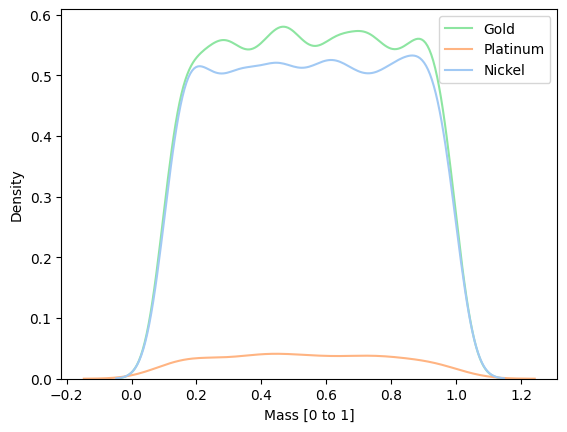

In [8]:
g = sns.kdeplot(data.filter(pl.col("Material Type") != 3),
                x="Mass [0 to 1]",
                hue="Material Type",
                palette="pastel")
# Transform legend label to material name
labels = ["Gold", "Platinum", "Nickel"]
g.legend(labels=labels)

# Evaluation code

Also, the hosted provided us with an [evaluation code](https://api.optimize.esa.int/media/problems/spoc-mining-mine-the-belt-1679404403080.py) to compute the score passing a list of asteroid, times of arrival and times of mining:

In [9]:
import numpy as np
import pykep as pk

################
### Constants
################

# Start and end epochs
T_START = pk.epoch_from_iso_string("30190302T000000")
T_END = pk.epoch_from_iso_string("30240302T000000")

# Cavendish constant (m^3/s^2/kg)
G = 6.67430e-11

# Sun_mass (kg)
SM = 1.989e30

# Mass and Mu of the Trappist-1 star
MS = 8.98266512e-2 * SM
MU_TRAPPIST = G * MS

# DV per fuel [m/s]
DV_per_fuel = 10000

# Maximum time to fully mine an asteroid
TIME_TO_MINE_FULLY = 30

# Loading the asteroid data
data = np.loadtxt("candidates.txt")
asteroids = []
for line in data:
    p = pk.planet.keplerian(
        T_START,
        (
            line[1],
            line[2],
            line[3],
            line[4],
            line[5],
            line[6],
        ),
        MU_TRAPPIST,
        G * line[7],  # mass in planet is not used in UDP, instead separate array below
        1,  # these variable are not relevant for this problem
        1.1,  # these variable are not relevant for this problem
        "Asteroid " + str(int(line[0])),
    )
    asteroids.append(p)

# And asteroids' masses and material type
asteroid_masses = data[:, -2]
asteroid_materials = data[:, -1].astype(int)


def convert_to_chromosome(solution, check_correctness=True):
    """Convert a solution to a fixed-length chromosome to be compatible with the optimize and pygmo framework.

    Args:
        solution (list or np.array): The solution to be converted. Has to have format [t_arrival_0, ..., t_arrival_n, t_mining_0, ..., t_mining_n, ast_id_0, ..., ast_id_n]
        check_correctness (bool): If True, the function will check if the solution fulfills some validity checks (unique asteroids, solution length).

    Returns:
        np.array: The chromosome as required by optimize / pygmo.
    """
    N = len(solution) // 3  # number of asteroids in chromosome
    ast_ids = solution[2 * N :]  # ids of the visited asteroids

    # Check if the solution is valid
    if check_correctness:
        assert (
            len(solution) % 3 == 0
        ), "Solution must be a multiple of 3 containing asteroid id, arrival time and time to mine. for each visit."

        assert (
            len(set(ast_ids)) - len(ast_ids) == 0
        ), "Asteroid IDs must be unique, can only visit each asteroid once."

    # The final chromosome will need to contain all asteroids, so we need to
    # add the asteroids to the chromosome that are not in the solution
    chromosome = np.zeros(30000, dtype=np.float64)

    # Set placeholder values for mining times and arrival times for irrelevant chromosome entries
    chromosome[N:10000] = 0
    chromosome[10000 + N : 20000] = 0

    # Add time of arrivals and mining times
    chromosome[:N] = solution[:N]
    chromosome[10000 : 10000 + N] = solution[N : 2 * N]

    # Add the asteroids that are in the solution
    chromosome[20000 : 20000 + N] = ast_ids

    # Add the asteroids that are not in the solution.
    # There is the potential of a very rare edgecase where by conincidence the next
    # asteroid added this way could still be visited but this is excessively unlikely
    ast_not_in_solution = set(np.arange(10000)).symmetric_difference(set(ast_ids))
    chromosome[20000 + N :] = np.array(list(ast_not_in_solution))

    return chromosome


class belt_mining_udp:
    """
    pygmo User Defined Problem (UDP) describing the optimization problem.
    https://esa.github.io/pygmo2/tutorials/coding_udp_simple.html explains what more details on UDPs.
    """

    def __init__(self, mission_window):
        """Initialize the UDP.

        Args:
            mission_window (list [float, float]): Bounds on the overall mission in days.
        """
        self.asteroids = asteroids
        self.asteroid_masses = asteroid_masses
        self.asteroid_materials_types = asteroid_materials
        self.mission_window = mission_window
        self.n = len(self.asteroids)
        self.MU = MU_TRAPPIST

    def get_bounds(self):
        """Get bounds for the decision variables.

        Returns:
            Tuple of lists: bounds for the decision variables.
        """
        lb = [self.mission_window[0]] * self.n + [0] * self.n + [0] * self.n
        ub = [self.mission_window[1]] * self.n + [60] * self.n + [self.n - 1] * self.n
        return (lb, ub)

    def get_nix(self):
        """Get number of integer variables.

        Returns:
            int: number of integer variables.
        """
        return self.n

    def get_nic(self):
        """Get number of inequality constraints.

        Returns:
            int: number of inequality constraints.
        """
        # Inequality constraints are only set to all visiting epochs (except the first)
        return self.n - 1

    def get_nec(self):
        """Get number of equality constraints.

        Returns:
            int: number of equality constraints.
        """
        # The only equality constraint is that each asteroid must be in the list exactly once
        return 1

    def fitness(self, x, verbose=False):
        """Evaluate the fitness of the decision variables.

        Args:
            x (numpy.array): Chromosome for the decision variables.
            verbose (bool): If True, print some info.

        Returns:
            float: Fitness of the chromosome.
        """
        fuel = 1  # fuel level of the ship, cannot go below 0 or we abort
        visited = 0  # viable number of visited asteroids, will be computed
        n = len(x) // 3  # number of asteroids in chromosome
        time_at_arrival = x[:n]  # time at arrival of each asteroid in days
        time_spent_mining = x[n : 2 * n]  # how many days spent mining each asteroid
        material_collected = [0] * 4  # last is fuel and will be disregarded for score
        ast_ids = x[2 * n :]  # ids of the visited asteroids
        if verbose:
            print(f"ID\tt0\tFuel \tDV \t  Material ID\t Prepared \t \tScore")

        # Lets compute the fitness
        for i in range(1, n):

            # Get indices of currently visited asteroid
            # and the previous one
            current_ast_id = int(ast_ids[i])
            previous_ast_id = int(ast_ids[i - 1])

            ###################### Step 1 #######################
            # Validate the transfer from asteroid i to i+1      #
            #####################################################

            # Break as soon as we exceed mission window
            if time_at_arrival[i] - time_at_arrival[0] > self.mission_window[1]:
                if verbose:
                    print("Mission window exceeded")
                break

            # Also break if the time of flight is too short (avoids singular lambert solutions)
            tof = time_at_arrival[i] - time_at_arrival[i - 1] - time_spent_mining[i - 1]
            if tof < 0.1:
                if verbose:
                    print("Time of flight too short or reached of chain.")
                break

            # Compute the ephemeris of the asteroid we are departing
            r1, v1 = self.asteroids[previous_ast_id].eph(
                T_START.mjd2000 + time_at_arrival[i - 1] + time_spent_mining[i - 1]
            )

            # Compute the ephemeris of the next target asteroid
            r2, v2 = self.asteroids[current_ast_id].eph(
                T_START.mjd2000 + time_at_arrival[i]
            )

            # Solve the lambert problem for this flight
            l = pk.lambert_problem(
                r1=r1, r2=r2, tof=tof * pk.DAY2SEC, mu=self.MU, cw=False, max_revs=0
            )

            # Compute the delta-v necessary to go there and match its velocity
            DV1 = [a - b for a, b in zip(v1, l.get_v1()[0])]
            DV2 = [a - b for a, b in zip(v2, l.get_v2()[0])]
            DV = np.linalg.norm(DV1) + np.linalg.norm(DV2)

            # Compute fuel used for this transfer and update ship fuel level
            fuel = fuel - DV / DV_per_fuel

            # Break if we ran out of fuel during this transfer
            if fuel < 0:
                if verbose:
                    print("Out of fuel")
                break

            ###################### Step 2 #######################
            # If we are here, this asteroid-to-asteroid         #
            # jump is possible and we accumulate the mining     #
            # resource to the objective function.               #
            #####################################################

            # Get material of the asteroid we are visiting
            mat_idx = self.asteroid_materials_types[current_ast_id]

            # Collect as much material as is there or we have time to
            material_collected[mat_idx] += np.minimum(
                self.asteroid_masses[current_ast_id],
                time_spent_mining[i] / TIME_TO_MINE_FULLY,
            )

            # If this is a fuel asteroid, we add it to the fuel
            if mat_idx == 3:
                fuel_found = np.minimum(
                    self.asteroid_masses[current_ast_id],
                    time_spent_mining[i] / TIME_TO_MINE_FULLY,
                )
                fuel = np.minimum(1.0, fuel + fuel_found)

            if verbose:
                tank = f"{material_collected[0]:.2f}|{material_collected[1]:.2f}|{material_collected[2]:.2f}"
                score = np.min(material_collected[:3])
                print(
                    f"{current_ast_id}\t{time_at_arrival[i]:<4.2f}\t{fuel:<7.2f}\t{DV:<8.2f}\t{mat_idx}\t {tank}\t\t{score:.2f}"
                )

            visited = visited + 1

        # The object function in the end is the minimum
        # collected mass of the three non-fuel material types.
        obj = np.min(material_collected[:3])

        # Now the constraints
        # The visited asteroid ids must all be different (equality)
        ec = len(set(ast_ids[:visited])) - len(ast_ids[:visited])
        # The visiting epoch must be after the previous visiting epoch plus the mining time (inequalities)
        ic = [0] * (n - 1)
        for i in range(1, visited):
            ic[i] = (
                time_at_arrival[i - 1] + time_spent_mining[i - 1] - time_at_arrival[i]
            )
        return [-obj] + [ec] + ic

    def pretty(self, x):
        """Pretty print the chromosome.

        Args:
            x (numpy.array): Chromosome for the decision variables.

        Returns:
            str: Pretty print of the chromosome.
        """
        self.fitness(x, True)

    def example(self):
        """Returns an example solution."""
        # (disable automatic formatting for this)
        # fmt: off
        t_arr = [0, 11.0, 45.98091676982585, 98.86574387748259, 144.3421379448264, 178.78720680368133, 198.49061810149578, 236.39180345018394, 268.4772894184571]
        t_m = [0, 18.980916769828053, 22.88482710766111, 29.47639406736512, 17.445068858837555, 18.703411297804774, 19.901185348707877, 24.085485968277332, 17.543366859589646]
        a = [0, 1446, 5131, 4449, 8091, 1516, 151, 4905, 8490]
        # fmt: on
        return convert_to_chromosome(t_arr + t_m + a)


udp = belt_mining_udp([0, 1827.0])

This code just initialize the `belt_mining_udp` class passing it the `mission_window` parameter. As you can see, in the evaluation code there is a method called `example` that passes the `time of arrival`, *t_arr*, `time mining`, *t_m*, and `asteroids`, `a`, arrays as a unique array to `convert_to_chromosome` function that returns a 30000x1 array:

In [10]:
chromosome = udp.example()
chromosome.shape

(30000,)

Also, we have the `pretty` method that accepts our chromosome array and evalutate it returning the rover journey parametes, the material extracted and the score.

In [11]:
udp.pretty(chromosome)

ID	t0	Fuel 	DV 	  Material ID	 Prepared 	 	Score
1446	11.00	0.44   	5553.30 	0	 0.63|0.00|0.00		0.00
5131	45.98	0.36   	805.87  	0	 1.40|0.00|0.00		0.00
4449	98.87	0.28   	847.84  	2	 1.40|0.00|0.98		0.00
8091	144.34	0.21   	716.05  	2	 1.40|0.00|1.56		0.00
1516	178.79	0.74   	928.60  	3	 1.40|0.00|1.56		0.00
151	198.49	0.33   	4127.70 	0	 2.06|0.00|1.56		0.00
4905	236.39	0.83   	3031.92 	3	 2.06|0.00|1.56		0.00
8490	268.48	0.39   	4376.36 	1	 2.06|0.58|1.56		0.58
Time of flight too short or reached of chain.


As you can see, in the `example` method of the evaluation code, 0.58 units of platinum have been recollected by the rover in its journey, being this value the challenge score according to the challenge's objectives

# Conclusion

In this notebook, we introduced the SpOC Mine the Belt challenge and had a first contact with the ESA astrodynamics Python package, `pykep`. We extract the first insights of the challenge:
- The asteroids are not balanced by material type.
- There are less material of platinum asteroids (163.02) setting the maximum theoretical score of the challenge.
- The asteroids are balanced by mass separated by material type.

Also we executed the example of evaluation code and obtains a score of `0.58`.

In the following notebooks, we are going to try to exceed this score with our own algorithms.

See you! 👋